In [2]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools absl-py

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [24]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_labels_paper import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-05-10 20:51:04.864947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 20:51:04.871404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 20:51:04.871621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [17]:
BATCH_SIZE = 32
FROM_LOGITS = True
LEARNING_RATE = 0.0001
INFO = "-"
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [18]:

opt = Adam(learning_rate=LEARNING_RATE)
resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape = (224,224,3))
# input = Input(shape=(224,224,3))
# encoder = resnet50(input)
# encoder_output = Conv2D(BOTTLENECK_DEPTH, 1, activation="relu", padding="same")(encoder)

input = Input(shape=(224,224,3))
encoder = resnet50(input)
avg_pool = AvgPool2D(2)(encoder)
flat = Flatten()(avg_pool)
fc = Dense(len(coco_labels))(flat)
model = Model(input, fc)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=opt, metrics=METRICS)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 average_pooling2d_6 (Averag  (None, 3, 3, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 91)                1677403   
                                                                 
Total params: 25,242,203
Trainable params: 25,196,763
Non-trainable params: 45,440
__________________________________________

2
['1401' '0' '17' '14' '61' '0' '317' '745' '292' '44' '20779' '976' '2'
 '945' '77' '1285' '20' '2163' '992' '70' '181' '38' '718' '570' '286'
 '1275' '30' '0' '6' '321' '1480' '193' '118' '229' '1002' '118' '575'
 '349' '0' '734' '332' '710' '702' '97' '339' '187' '481' '1977' '6592'
 '0' '6' '844' '7' '379' '1592' '5' '0' '0' '2086' '103' '33' '403' '0'
 '91' '249' '932' '1381' '103' '307' '25' '744' '623' '221' '59' '958'
 '179' '879' '366' '792' '508' '236' '0' '7' '809' '0' '2605' '0' '310'
 '188' '529' '1945']


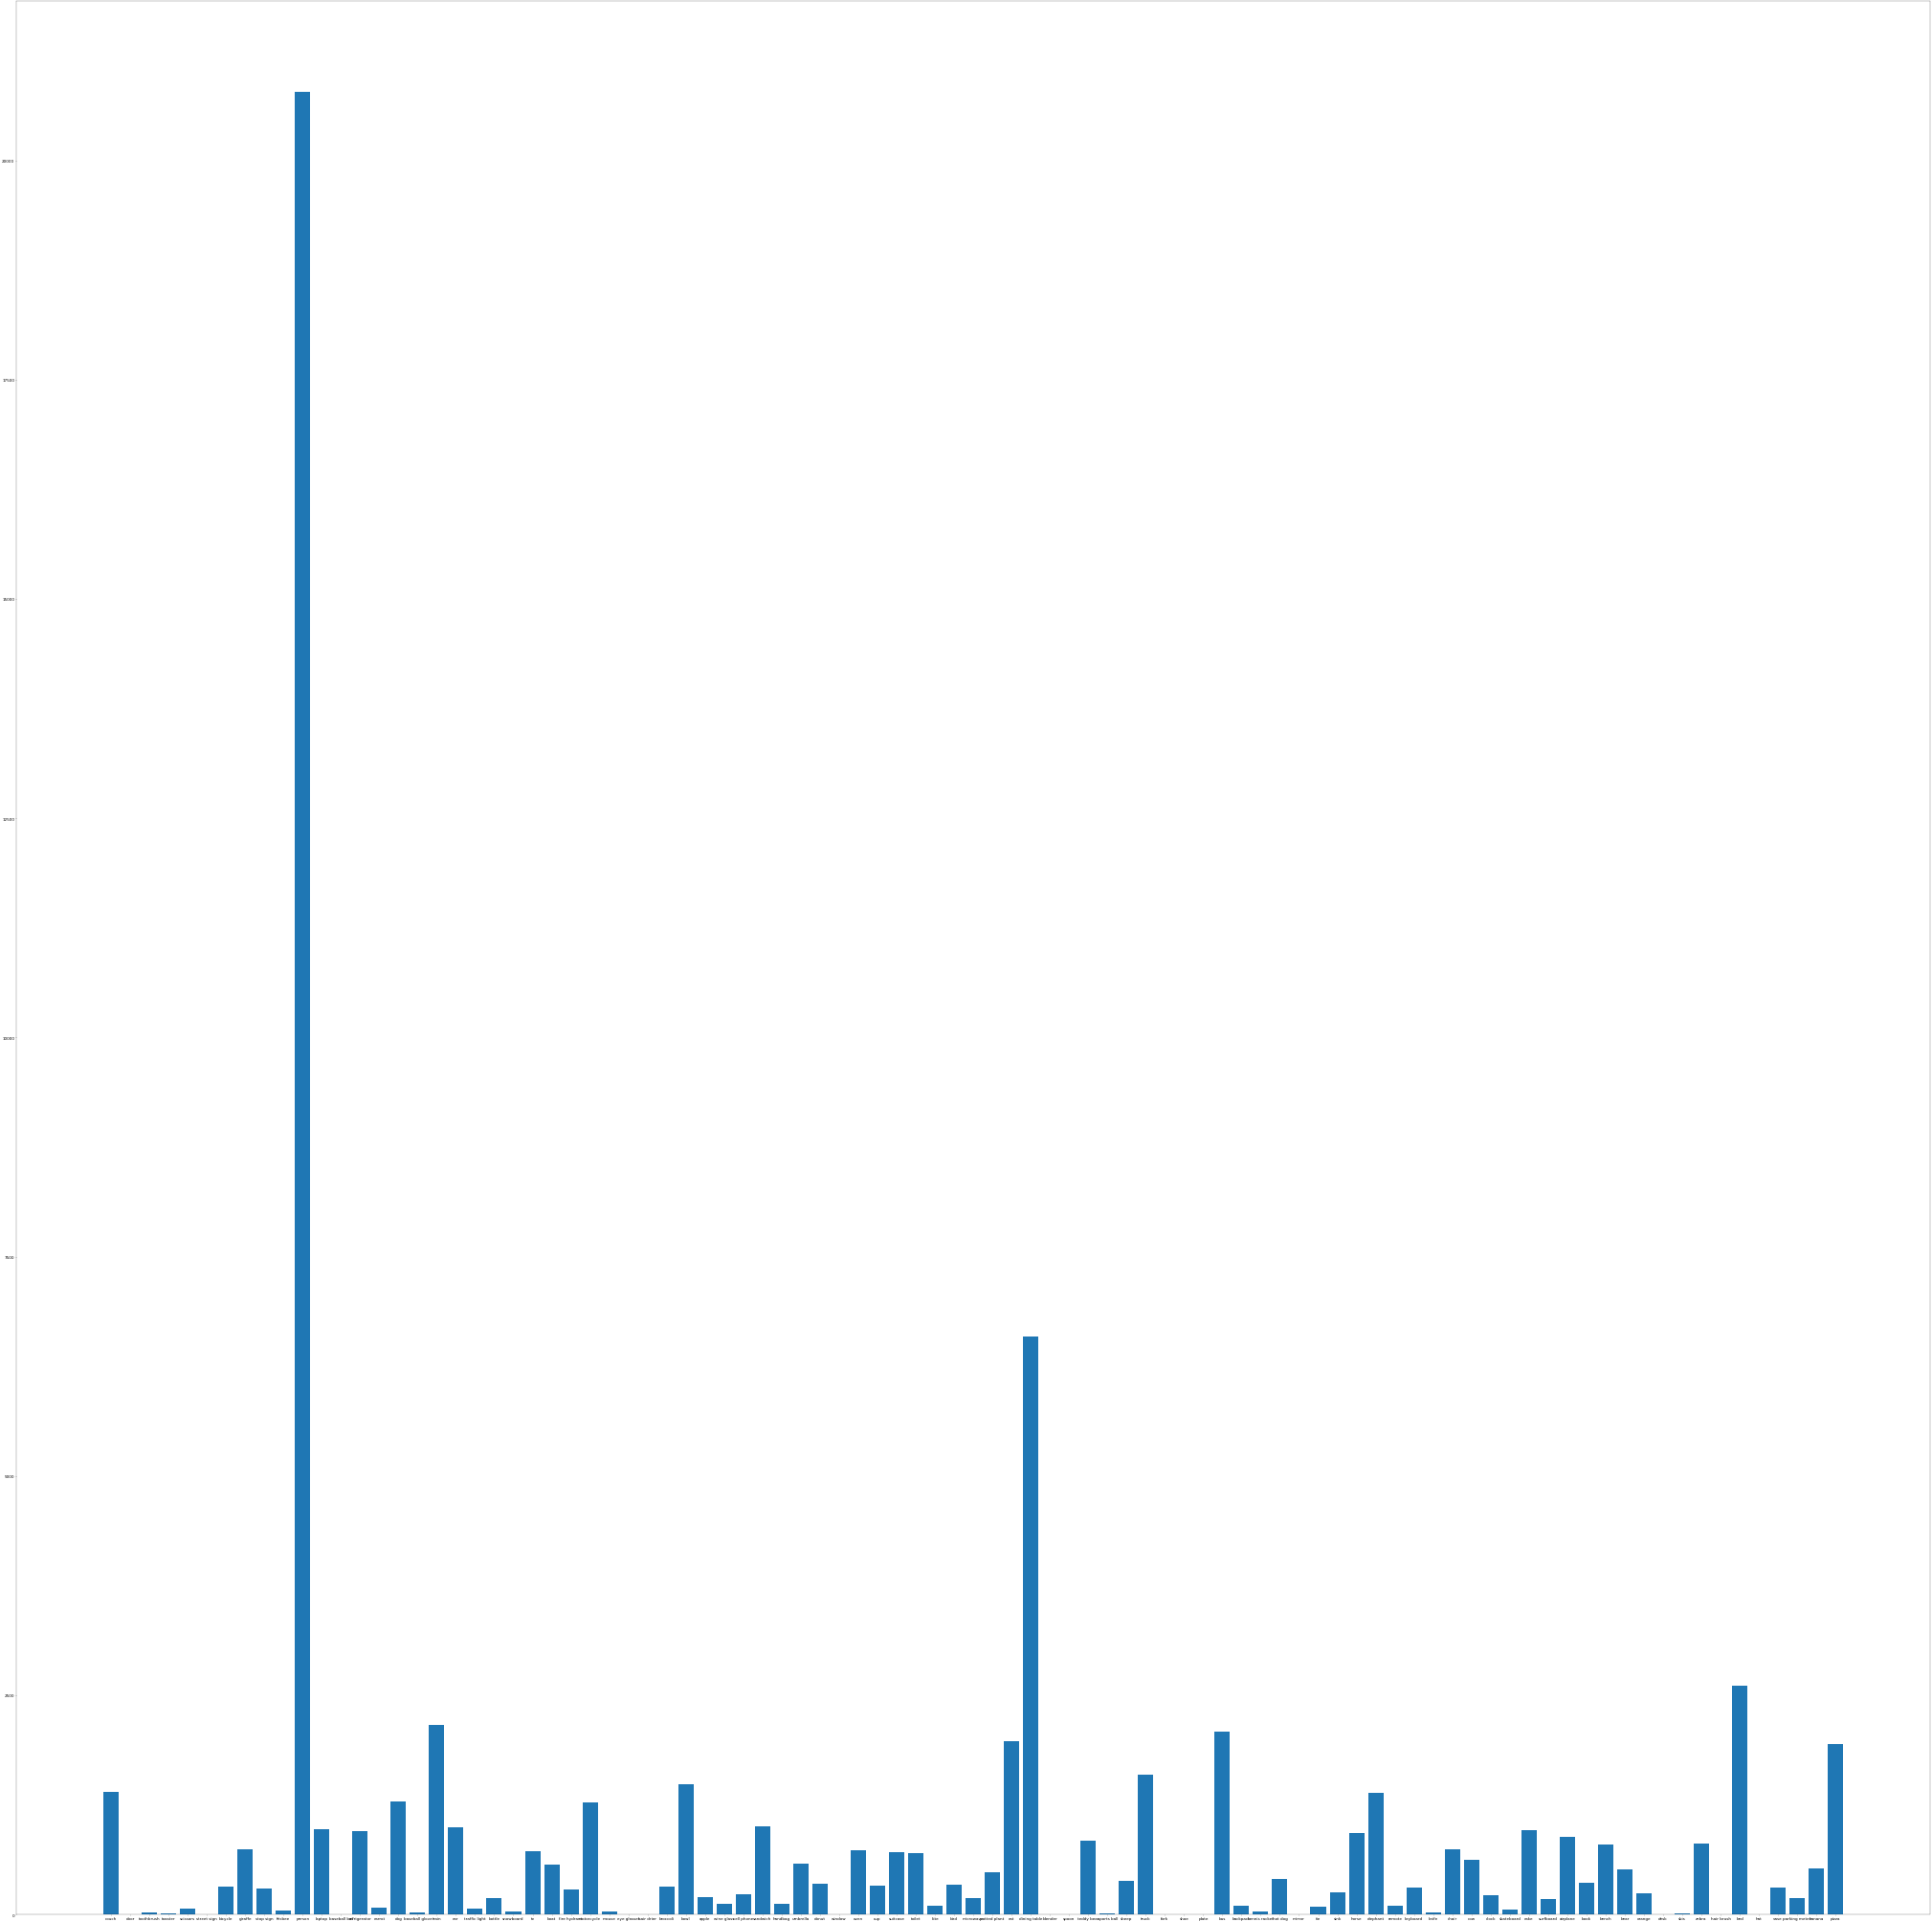

In [19]:
amounts = []
for c in os.listdir("data/coco_onehot_train"):
    amounts.append((c, len(os.listdir("data/coco_onehot_train/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 15})
fig = plt.pyplot.figure(figsize=(100,100), dpi=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

print(min({x for x in np.asarray(amounts[:,1],dtype=int) if x > 0}))
print(amounts[:,1])

In [21]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
70


In [39]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess(anchor, label):
    return (load_images(anchor), label)

def get_training_data(epoch_size=1024, training: bool=True):
    X = []
    Y = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(epoch_size):
        c = random.choice(available_classes)
        anchor = random.choice(image_set[c])
        X.append(f"{image_dir}/{c}/{anchor}")
        index = coco_labels.index(c)
        lbl = np.zeros(len(coco_labels))
        lbl[index] = 1
        Y.append(lbl)

    return (X, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess)
    return processed_data

In [6]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img/255
    lbl = tf.strings.split(path, os.path.sep)[-2]
    lbl = lbl == coco_labels
    return img, tf.one_hot(tf.argmax(lbl), len(coco_labels))

tf_dataset = tf.data.Dataset.list_files('coco_onehot_data/*/*')

AUTOTUNE = tf.data.AUTOTUNE

val_size = int(len(tf_dataset)*0.1)
train_ds = tf_dataset.skip(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
val_ds = tf_dataset.take(val_size).map(load_images, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

(array([[[0.30980393, 0.2901961 , 0.30588236],
        [0.31764707, 0.29803923, 0.3137255 ],
        [0.30588236, 0.28627452, 0.3019608 ],
        ...,
        [0.50980395, 0.3529412 , 0.2509804 ],
        [0.5176471 , 0.35686275, 0.2784314 ],
        [0.5137255 , 0.3529412 , 0.28235295]],

       [[0.3529412 , 0.3372549 , 0.34117648],
        [0.3529412 , 0.3372549 , 0.34117648],
        [0.34117648, 0.3254902 , 0.32941177],
        ...,
        [0.47058824, 0.3137255 , 0.21176471],
        [0.47843137, 0.31764707, 0.23137255],
        [0.5058824 , 0.34509805, 0.26666668]],

       [[0.37254903, 0.3529412 , 0.3372549 ],
        [0.34117648, 0.32156864, 0.30588236],
        [0.34117648, 0.32156864, 0.30588236],
        ...,
        [0.5019608 , 0.34901962, 0.23529412],
        [0.5019608 , 0.3372549 , 0.24313726],
        [0.50980395, 0.34509805, 0.2509804 ]],

       ...,

       [[0.02352941, 0.04313726, 0.01960784],
        [0.02352941, 0.04313726, 0.01960784],
        [0.01960784, 

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

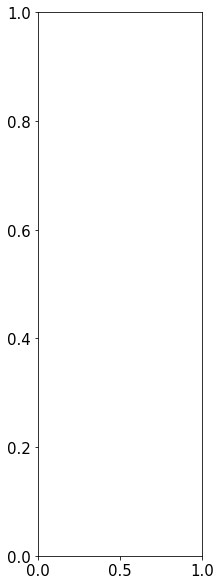

In [45]:
dataset = get_training_dataset(3, False)
dataset = dataset.as_numpy_iterator()
print(next(dataset))

plt.pyplot.figure(figsize=(10,10))
for i in range(3):
    ax = plt.pyplot.subplot(1,3,i+1)
    plt.pyplot.imshow(next(dataset)[0].numpy().astype("float32"))
    label = lbl_batch[i].numpy()
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels[label])
    plt.pyplot.axis("off")

In [46]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet50

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet50/{0}'.format(current_time)
weight_dir = 'weights/resnet50/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_freq=100)

In [47]:
def train(EPOCHS):
    print("Starting training...")

    train_data = get_training_dataset(4096*64)
    train_data = train_data.batch(32)
    train_data = train_data.prefetch(32)

    val_data = get_training_dataset(4096)
    val_data = val_data.batch(32)
    val_data = val_data.prefetch(32)

    #loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    hist_train = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback], epochs=1)

train(10)

Starting training...


2022-05-10 21:34:45.641938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-10 21:34:46.047084: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-10 21:34:47.268933: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_161555/2355126188.py", line 15, in <cell line: 15>
      train(10)
    File "/tmp/ipykernel_161555/2355126188.py", line 13, in train
      hist_train = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback], epochs=1)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/metrics.py", line 1073, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_161555/2355126188.py", line 15, in <cell line: 15>
      train(10)
    File "/tmp/ipykernel_161555/2355126188.py", line 13, in train
      hist_train = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback], epochs=1)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/metrics.py", line 1073, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/dense_4/BiasAdd:0) = ] [[-3.30212665 0.548800051 -1.56519234...]...] [y (Cast_4/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_2/Assert/AssertGuard/pivot_f/_43/_89]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_6/dense_4/BiasAdd:0) = ] [[-3.30212665 0.548800051 -1.56519234...]...] [y (Cast_4/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_48731]

In [10]:
resnet.model.save_weights(os.path.join(weight_dir, weight_file.format("_onehot")))

In [12]:

resnet.model.evaluate(validation_ds, verbose=1)


14/14 [==============================] - 2s 151ms/step - loss: 2.2457 - accuracy: 0.6529


[2.2457149028778076, 0.6528735756874084]